In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras_tuner as kt
import sklearn
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report





# 1. Data Analysis

In [5]:
# Load the dataset
train = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_train.csv")

In [6]:
# Extract predictors and target variable
train_x = train.iloc[:, 1:].values
train_y = train['label'].values

In [7]:
# Normalize the predictors
train_x = train_x / 255.0

# Reshape for convolutional layers
train_x = train_x.reshape(-1, 28, 28, 1)

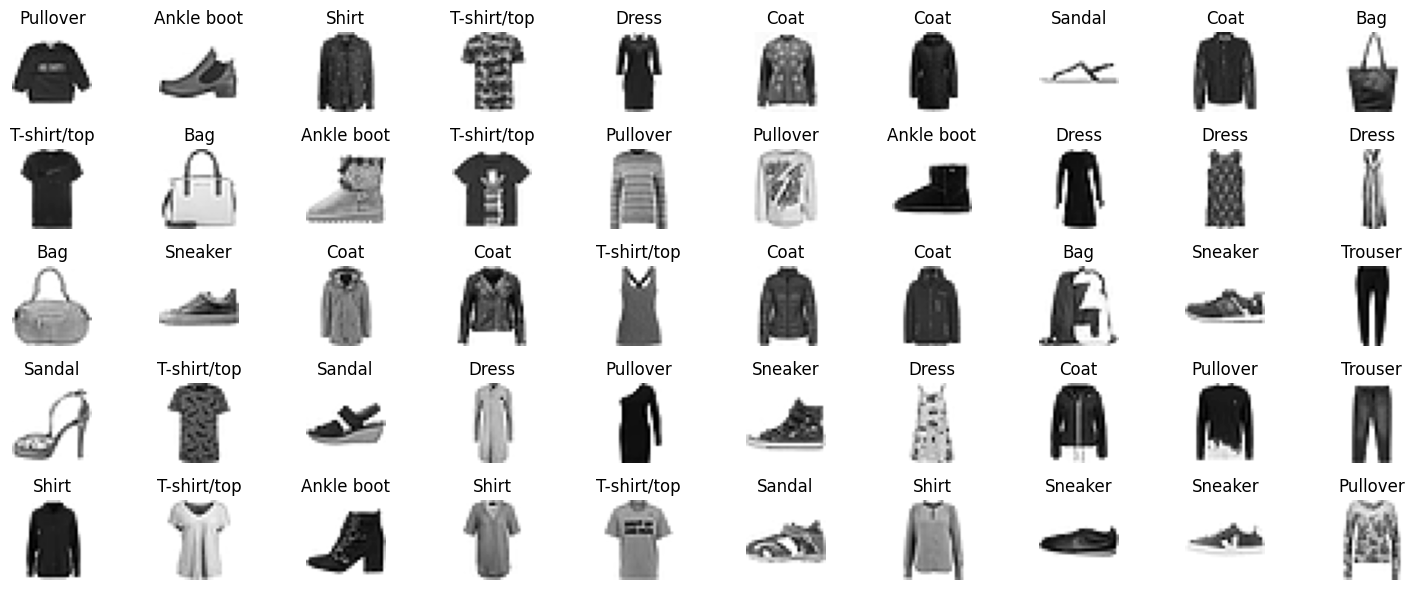

In [8]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

plt.figure(figsize=(15, 6))
plotnumber = 1

for i in range(51):
    if plotnumber <= 50:
        ax = plt.subplot(5, 10, plotnumber)
        plt.imshow(train_x[i], cmap=plt.cm.binary)
        plt.axis('off')
        plt.title(class_names[train_y[i]], fontdict={'fontsize': 12, 'color': 'black'})
        
    plotnumber += 1

plt.tight_layout()
plt.show()


In [9]:
#More deep dive into dataset properties visualization
train.describe()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,...,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.000000,60000.00000
mean,4.500000,0.000900,0.006150,0.035333,0.101933,0.247967,0.411467,0.805767,2.198283,5.682000,...,34.625400,23.300683,16.588267,17.869433,22.814817,17.911483,8.520633,2.753300,0.855517,0.07025
std,2.872305,0.094689,0.271011,1.222324,2.452871,4.306912,5.836188,8.215169,14.093378,23.819481,...,57.545242,48.854427,41.979611,43.966032,51.830477,45.149388,29.614859,17.397652,9.356960,2.12587
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,4.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,58.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,9.000000,16.000000,36.000000,226.000000,164.000000,227.000000,230.000000,224.000000,255.000000,254.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,170.00000


In [10]:
# Print the class distribution
unique, counts = np.unique(train_y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution:")
for label, count in class_distribution.items():
    print(f"Class {label}: {count} samples")

Class Distribution:
Class 0: 6000 samples
Class 1: 6000 samples
Class 2: 6000 samples
Class 3: 6000 samples
Class 4: 6000 samples
Class 5: 6000 samples
Class 6: 6000 samples
Class 7: 6000 samples
Class 8: 6000 samples
Class 9: 6000 samples


1.Class Distribution:The dataset consists of 10 classes, each representing a different type of clothing or accessory.
2.Nature of Images:The images are grayscale and have a resolution of 28x28 pixels..
3.Patterns:Some classes might have distinct patterns that are easy to recognize. For example, shoes often have a sole pattern, and shirts may have distinctive collars or sleeves.Some classes might be more challenging to distinguish, especially if they share similar shapes or textures.


# 2. **Model Development**:

In [11]:
# Split data into training and validation sets
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

# Define the number of classes
NUM_CLASSES = 10

# Define a simplified ResNet-18 architecture
def residual_block(x, filters, kernel_size=3, stride=1):
    # Shortcut connection
    shortcut = x
    
    # First convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Second convolution layer
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    # Add shortcut to the output
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x



In [12]:
input_layer = Input(shape=(28, 28, 1))

# Initial Convolution
x = Conv2D(64, kernel_size=7, strides=2, padding='same')(input_layer)
x = BatchNormalization()(x)
x = ReLU()(x)

# Residual blocks
for _ in range(2):
    x = residual_block(x, filters=64)

x = Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

for _ in range(2):
    x = residual_block(x, filters=128)

x = Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

for _ in range(2):
    x = residual_block(x, filters=256)

x = GlobalAveragePooling2D()(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=10, batch_size=32)



Epoch 1/10
1500/1500 [==============================] - 37s 12ms/step - loss: 0.4516 - accuracy: 0.8353 - val_loss: 0.3834 - val_accuracy: 0.8599
Epoch 2/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.3072 - accuracy: 0.8871 - val_loss: 0.3130 - val_accuracy: 0.8829
Epoch 3/10
1500/1500 [==============================] - 17s 12ms/step - loss: 0.2641 - accuracy: 0.9023 - val_loss: 0.2872 - val_accuracy: 0.8929
Epoch 4/10
1500/1500 [==============================] - 17s 12ms/step - loss: 0.2294 - accuracy: 0.9161 - val_loss: 0.3007 - val_accuracy: 0.8932
Epoch 5/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.2001 - accuracy: 0.9273 - val_loss: 0.2460 - val_accuracy: 0.9084
Epoch 6/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.1751 - accuracy: 0.9361 - val_loss: 0.2334 - val_accuracy: 0.9144
Epoch 7/10
1500/1500 [==============================] - 18s 12ms/step - loss: 0.1510 - accuracy: 0.9429 - val_loss: 0.2411 -

In [13]:
# Load and preprocess test data
test = pd.read_csv("/kaggle/input/fashionmnist/fashion-mnist_test.csv")
test_x = test.iloc[:, 1:].values
test_x = test_x / 255.0
test_x = test_x.reshape(-1, 28, 28, 1)
test_y = test['label'].values

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_x, test_y)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

313/313 [==============================] - 2s 5ms/step - loss: 0.2695 - accuracy: 0.9231
Test Accuracy: 92.31%


313/313 [==============================] - 1s 3ms/step


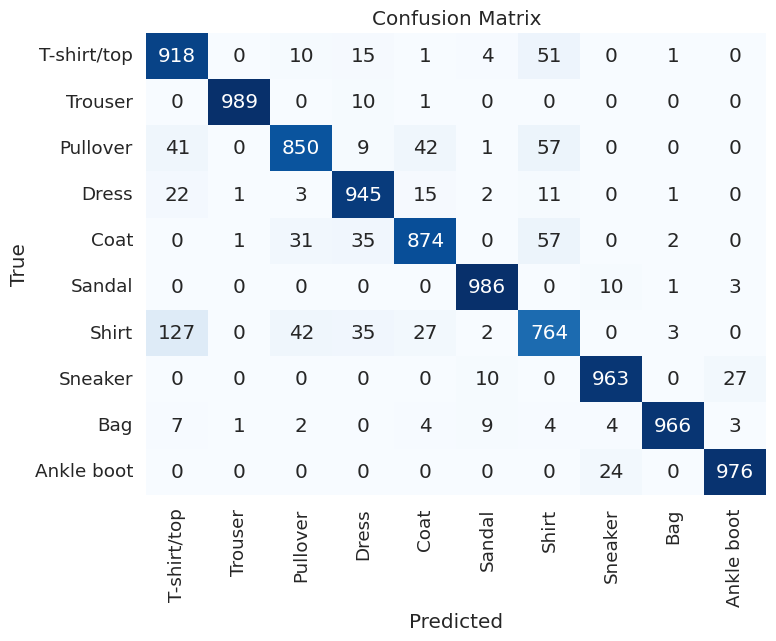

              precision    recall  f1-score   support

 T-shirt/top       0.82      0.92      0.87      1000
     Trouser       1.00      0.99      0.99      1000
    Pullover       0.91      0.85      0.88      1000
       Dress       0.90      0.94      0.92      1000
        Coat       0.91      0.87      0.89      1000
      Sandal       0.97      0.99      0.98      1000
       Shirt       0.81      0.76      0.79      1000
     Sneaker       0.96      0.96      0.96      1000
         Bag       0.99      0.97      0.98      1000
  Ankle boot       0.97      0.98      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [16]:

# Generate Predictions on the Test Set
predictions = model.predict(test_x)
predicted_labels = np.argmax(predictions, axis=1)

# Generate Confusion Matrix
cm = confusion_matrix(test_y, predicted_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Generate Classification Report for F1 Score, Precision, Recall, etc.
report = classification_report(test_y, predicted_labels, target_names=class_names)

# Print Classification Report
print(report)



In [21]:
#keras.utils.plot_model(model, show_shapes=True)
#model.summary()


# 3. **Human-in-the-Loop**:

To incorporate human expertise in a Human-in-the-Loop (HITL) approach, we can use active learning techniques. Active learning is a semi-supervised learning method where the model requests labels for specific data points from an expert (human) to improve its performance.
Here's a suggested approach:
1.	Uncertainty Sampling:
	Implement a strategy that selects data points where the model is uncertain about its predictions.
	Use metrics like prediction confidence to identify samples where the model's confidence is low.
2.	Human Labeling:
	Present the selected uncertain samples to a human expert for labeling.
	Collect the ground truth labels for these samples.
3.	Model Update:
	Incorporate the newly labeled data into your training set.
4.	Retraining:
	Retrain your model on the updated dataset.


In [22]:
# Define a function to select uncertain samples
def get_uncertain_samples(model, data):
    predictions = model.predict(data)
    confidence = np.max(predictions, axis=1)
    uncertain_indices = np.argsort(confidence)[:NUM_SAMPLES_TO_LABEL]
    return uncertain_indices

In [ ]:
# Initialize the process
NUM_SAMPLES_TO_LABEL = 10
NUM_ITERATIONS=10
for iteration in range(NUM_ITERATIONS):
    # Step 1: Get uncertain samples
    uncertain_indices = get_uncertain_samples(model, unlabeled_data)

    # Step 2: Present samples to human expert for labeling
    human_labels = label_data(unlabeled_data[uncertain_indices])

    # Step 3: Add new labels to training set
    train_x = np.vstack((train_x, unlabeled_data[uncertain_indices]))
    train_y = np.concatenate((train_y, human_labels))

    # Step 4: Retrain the model
    history = model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=1, batch_size=32, verbose=0)

    # Update the list of unlabeled data
    unlabeled_data = np.delete(unlabeled_data, uncertain_indices, axis=0)